## Part B4 - Price Modeling by Sampling

### 4.1 - Import Libraries & Loading Data

In [1]:
# Cell 1: Import libraries and load preprocessed dataset

# --- Core Libraries ---
import pandas as pd
import numpy as np
import random
import warnings

from sklearn.model_selection import train_test_split

from datetime import datetime

# --- Machine Learning Models & Metrics ---
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler 

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Progress Bar ---
from tqdm import tqdm
tqdm.pandas()

# --- Silence Warnings ---
warnings.simplefilter("ignore", ConvergenceWarning)


### 4.2 - Data Preproseccing

pp

In [ ]:
def load_and_filter_data(csv_path):
    """
    Load, clean, filter, and engineer features from the hotel pricing dataset.

    Parameters:
    - csv_path: path to the CSV file

    Returns:
    - df: filtered raw data
    - df_engineered: feature-engineered version of the data
    - grouped: list of (Hotel Name, Snapshot Date, Discount Code) groups with enough data
    """

    # Step 1: Load raw data
    df = pd.read_csv(csv_path)
    print("Step 1 - Initial rows:", df.shape[0])

    # Step 2: Remove rows with missing Discount Price
    df = df[df['Discount Price'].notna()]
    print("Step 2 - After removing missing Discount Price:", df.shape[0])

    # Step 3: Keep top 40 hotels with the most data
    top_40_hotels = df['Hotel Name'].value_counts().head(40).index
    df = df[df['Hotel Name'].isin(top_40_hotels)]
    print("Step 3 - After keeping only top 40 hotels:", df.shape[0])

    # Step 4: Filter to only include rows within 30 days
    df = df[df['DayDiff'] <= 30]
    print("Step 4 - After filtering DayDiff ≤ 30:", df.shape[0])

    # Step 5: Group by hotel, snapshot date and discount code
    grouped = df.groupby(['Hotel Name', 'Snapshot Date', 'Discount Code']).size().reset_index(name='Count')
    print("Step 5 - Total groups after grouping:", grouped.shape[0])

    # Step 6: Keep only groups with at least 5 samples
    grouped = grouped[grouped['Count'] >= 5].copy()
    print("Step 6 - Groups with Count ≥ 5:", grouped.shape[0])

    # Step 7: Sort by Count descending and reset index
    grouped = grouped.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Step 8: Preview top 10 groups
    print("\nTop 10 groups with the highest number of samples:")
    display(grouped.head(10))

    # Step 9: Feature engineering
    df = df.copy()
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    df['Checkin_Date_num'] = df['Checkin Date'].apply(lambda x: x.timestamp())

    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['WeekDay_num'] = df['WeekDay'].map(weekday_map)

    # Drop unnecessary columns if they exist
    drop_cols = ['Snapshot ID', 'Checkin Date', 'WeekDay']
    df_engineered = df.drop(columns=[col for col in drop_cols if col in df.columns])

    return df, df_engineered, grouped


# Load and process data
df, df_engineered, grouped = load_and_filter_data("Data/Hotels_data_Changed.csv")


Step 1 - Initial rows: 187848
Step 2 - After removing missing Discount Price: 187848
Step 3 - After keeping only top 40 hotels: 101564
Step 4 - After filtering DayDiff ≤ 30: 88700
Step 5 - Total groups after grouping: 19224
Step 6 - Groups with Count ≥ 5: 7503

Top 10 groups with the highest number of samples:


,Hotel Name,Snapshot Date,Discount Code,Count
0,Park Hyatt New York,2015-07-22,3,44
1,Park Hyatt New York,2015-07-22,2,43
2,The New York EDITION,2015-07-27,2,30
3,The New York EDITION,2015-07-29,3,30
4,The New York EDITION,2015-07-29,2,30
5,The New York EDITION,2015-07-27,3,30
6,Newark Liberty International Airport Marriott,2015-07-23,3,30
7,Park Hyatt New York,2015-07-22,1,30
8,Newark Liberty International Airport Marriott,2015-07-22,3,30
9,The New York EDITION,2015-07-28,3,29


### 4.3 - Train model & Feature

#### 4.3.1 - Feature 

In [86]:
# Cell 3: Feature Engineering + Normalization

def feature_engineering(df):
    df = df.copy()
    
    # Convert date to ordinal
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    df['Checkin_Ordinal'] = df['Checkin Date'].map(pd.Timestamp.toordinal)

    # Map weekdays
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['Weekday_Num'] = df['WeekDay'].map(weekday_map)

    # Drop unnecessary
    drop_cols = ['Snapshot ID', 'Checkin Date', 'WeekDay']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    return df


def normalize(df, features_to_scale, scaler=None):
    df_scaled = df.copy()
    if scaler is None:
        scaler = StandardScaler()
        df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    else:
        df_scaled[features_to_scale] = scaler.transform(df_scaled[features_to_scale])
    return df_scaled, scaler


# Run on full dataset
df_engineered = feature_engineering(df)

features_to_scale = [
    "Checkin_Ordinal", "Original Price", "Discount Price",
    "Available Rooms", "DayDiff", "DiscountDiff", "DiscountPerc"
]

df_normalized, fitted_scaler = normalize(df_engineered, features_to_scale)

print("✅ Feature engineering + normalization complete. New shape:", df_normalized.shape)
display(df_normalized.head())

✅ Feature engineering + normalization complete. New shape: (88700, 15)


,Snapshot Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc,Checkin_Date_num,WeekDay_num,Checkin_Ordinal,Weekday_Num
5,2015-07-17,5,-0.491999,-0.441439,1,-0.188199,Grand Hyatt New York,4,0.584424,-0.533819,-0.498849,1.438906e+09,4,-1.613710,4
6,2015-07-17,5,-0.335493,-0.275121,1,-0.294727,Grand Hyatt New York,4,0.815975,-0.533819,-0.604424,1.439078e+09,6,-1.571164,6
7,2015-07-17,5,-0.648505,-0.591126,1,-0.294727,Grand Hyatt New York,4,1.163301,-0.642883,-0.577365,1.439338e+09,2,-1.507344,2
8,2015-07-17,5,-0.648505,-0.574494,1,1.010247,Grand Hyatt New York,4,1.279076,-0.751947,-0.791717,1.439424e+09,3,-1.486071,3
14,2015-07-17,5,1.650395,1.780758,1,-0.214831,Park Hyatt New York,5,-1.267981,-0.176333,-0.871412,1.437523e+09,2,-1.954083,2


In [ ]:
# Cell 4: Splitting the dataset


# Split the normalized dataset
train_df, test_df = train_test_split(
    df_normalized,
    test_size=0.2,
    random_state=42,
    stratify=df_normalized['Hotel Name']  
)

print(f"✅ Training set size: {train_df.shape}")
print(f"✅ Test set size: {test_df.shape}")


#### 4.3.2 - train model

In [ ]:
# Cell 5: Updated Base Model Training (uses train_df)

def train_base_model(grouped_df, engineered_df, sample_size=5):
    results = []

    for _, row in tqdm(grouped_df.iterrows(), total=grouped_df.shape[0], desc="Training models"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Use training set only
        group_data = engineered_df[
            (engineered_df['Hotel Name'] == hotel) &
            (pd.to_datetime(engineered_df['Snapshot Date']) == snapshot_date) &
            (engineered_df['Discount Code'] == discount_code) &
            (engineered_df['DayDiff'] <= 30)
        ].copy()

        if group_data.shape[0] < sample_size:
            continue

        feature_candidates = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms',
            'DayDiff', 'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_candidates if f in group_data.columns]

        X_full = group_data[selected_features]
        y_full = group_data['Discount Price']

        sample = group_data.sample(n=sample_size, random_state=42)
        X_sample = sample[selected_features]
        y_sample = sample['Discount Price']

        model = LinearRegression()
        model.fit(X_sample, y_sample)

        y_pred = model.predict(X_full)
        r2 = r2_score(y_full, y_pred)

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Num Samples Used': sample_size,
            'Total Rows': group_data.shape[0],
            'R2 Score': r2
        })

    return pd.DataFrame(results)


In [ ]:
# Cell 6: Train base model on all valid groups

# Run training on train set
results_df = train_base_model(grouped, train_df, sample_size=5)


Training models: 100%|██████████| 7503/7503 [04:15<00:00, 29.37it/s]


✅ Number of models successfully trained: 7503
📈 Average R² score: 0.9881

✅ Good models: 7461
❌ Bad models: 42

📊 Statistical Comparison Between Good and Bad Models:


,Good Mean,Good Std,Bad Mean,Bad Std
Num Samples Used,5.000000,0.000000,5.000000,0.000000
Total Rows,8.064335,3.589811,11.357143,4.600220
R2 Score,0.996781,0.041221,-0.552548,0.565438


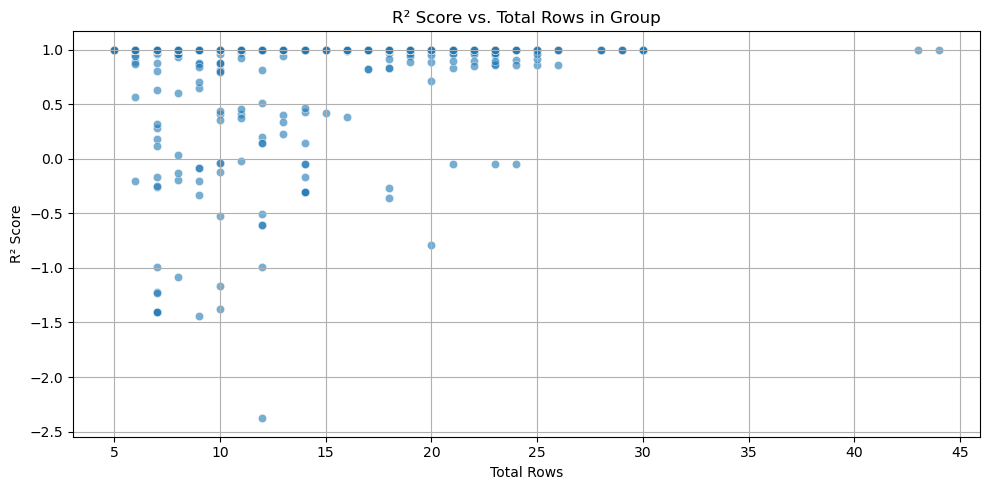

In [ ]:
# Cell 7: Analyze results – summary statistics and visualizations

# Check how many models were trained
print(f"✅ Number of models successfully trained: {results_df.shape[0]}")

# Calculate average R² score
average_r2 = results_df['R2 Score'].mean()
print(f"📈 Average R² score: {average_r2:.4f}")

# Split results based on R² score
good_models = results_df[results_df['R2 Score'] >= 0].copy()
bad_models = results_df[results_df['R2 Score'] < 0].copy()

print(f"\n✅ Good models: {len(good_models)}")
print(f"❌ Bad models: {len(bad_models)}")

# --- Statistical Summary ---

# Select only numeric columns manually
numeric_cols = ['Num Samples Used', 'Total Rows', 'R2 Score']

# Basic summary stats
good_stats = good_models[numeric_cols].describe().T
bad_stats = bad_models[numeric_cols].describe().T

# Combine summaries into a single comparison table
comparison = pd.concat([good_stats[['mean', 'std']], bad_stats[['mean', 'std']]], axis=1)
comparison.columns = ['Good Mean', 'Good Std', 'Bad Mean', 'Bad Std']

print("\n📊 Statistical Comparison Between Good and Bad Models:")
display(comparison)

# --- Visualizations ---

# Plot R² vs. Total Rows
plt.figure(figsize=(10, 5))
sns.scatterplot(data=results_df, x='Total Rows', y='R2 Score', alpha=0.6)
plt.title('R² Score vs. Total Rows in Group')
plt.xlabel('Total Rows')
plt.ylabel('R² Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 8: Enrich model results with engineered features

def enrich_results(subset, label):
    # Ensure Snapshot Date is in datetime format on both sides
    subset = subset.copy()
    subset['Snapshot Date'] = pd.to_datetime(subset['Snapshot Date'])
    df_engineered_copy = df_engineered.copy()
    df_engineered_copy['Snapshot Date'] = pd.to_datetime(df_engineered_copy['Snapshot Date'])

    merged = pd.merge(
        subset[['Hotel Name', 'Snapshot Date', 'Discount Code']],
        df_engineered_copy,
        on=['Hotel Name', 'Snapshot Date', 'Discount Code'],
        how='left'
    )
    merged['Performance'] = label
    return merged

# Split models based on R²
good_models = results_df[results_df['R2 Score'] >= 0]
bad_models = results_df[results_df['R2 Score'] < 0]

# Enrich both groups
good_data = enrich_results(good_models, 'Good')
bad_data = enrich_results(bad_models, 'Bad')

# Merge for further comparison
merged_all = pd.concat([good_data, bad_data], ignore_index=True)
print("✅ Enrichment complete. Combined shape:", merged_all.shape)


✅ Enrichment complete. Combined shape: (60645, 16)


### 4.4 - Analyze base model

### 4.6 - Active Sampling (GPR)

In [ ]:
# Cell 9: GPR Model Builder and Active Sampling Utilities

# Function to build a Gaussian Process Regressor with predefined kernel
def build_gpr_model():
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    model = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,
        alpha=1e-2,
        normalize_y=True
    )
    return model


# Active sampling loop with early stopping based on uncertainty and stagnation
def active_sampling_loop_with_stagnant_iterations_stop(
    X, y,
    max_iterations=15,
    uncertainty_threshold=0.05,
    higher_uncertainty_threshold=0.1,
    initial_sample_indices=None,
    r2_improvement_threshold=1e-4,
    max_stagnant_iterations=3
):
    n_samples = X.shape[0]

    # If no initial samples are provided, take first, middle, last
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]

    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []

    previous_r2 = -np.inf
    stagnant_iterations = 0

    for iteration in range(max_iterations):
        X_train = X.iloc[sorted(training_indices)]
        y_train = y.iloc[sorted(training_indices)]

        model = build_gpr_model()
        model.fit(X_train, y_train)

        candidate_list = sorted(candidate_indices)
        if not candidate_list:
            break

        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)

        # Select candidate with maximum uncertainty
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]

        # Evaluate model on full data
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)

        r2_improvement = current_r2 - previous_r2
        if r2_improvement < r2_improvement_threshold:
            stagnant_iterations += 1
        else:
            stagnant_iterations = 0

        previous_r2 = current_r2

        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2,
            'r2_improvement': r2_improvement
        })

        # Early stopping condition
        if (max_std < uncertainty_threshold) or (
            (max_std < higher_uncertainty_threshold) and (stagnant_iterations >= max_stagnant_iterations)
        ):
            break

        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)

    # Final model fit after active sampling
    X_final = X.iloc[sorted(training_indices)]
    y_final = y.iloc[sorted(training_indices)]
    final_model = build_gpr_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)

    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }


# Prepare data subset for a specific group and apply feature engineering
def prepare_group_data(group, df):
    df_subset = df[
        (df['Hotel Name'] == group['Hotel Name']) &
        (pd.to_datetime(df['Snapshot Date']) == pd.to_datetime(group['Snapshot Date'])) &
        (df['Discount Code'] == group['Discount Code'])
    ].copy()

    # Apply basic feature engineering
    df_subset['Checkin_Date_num'] = pd.to_datetime(df_subset['Checkin Date']).apply(lambda x: x.timestamp())
    weekday_map = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    df_subset['WeekDay_num'] = df_subset['WeekDay'].map(weekday_map)

    # Remove non-relevant columns
    drop_cols = ['Hotel Name', 'Snapshot Date', 'Checkin Date', 'WeekDay', 'Snapshot ID']
    df_subset.drop(columns=[col for col in drop_cols if col in df_subset.columns], inplace=True)

    # Select features and target
    features = ['Checkin_Date_num', 'WeekDay_num', 'Available Rooms', 'DayDiff',
                'Original Price', 'DiscountDiff', 'DiscountPerc']
    features = [f for f in features if f in df_subset.columns]

    X = df_subset[features]
    y = df_subset['Discount Price']

    # Normalize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

    return X_scaled, y, df_subset


# Select group with the most data for GPR demo
first_group = grouped.sort_values('Count', ascending=False).iloc[0]
X_one, y_one, original_subset = prepare_group_data(first_group, df)

# Run active GPR loop
result = active_sampling_loop_with_stagnant_iterations_stop(
    X_one, y_one,
    max_iterations=15,
    uncertainty_threshold=0.05,
    higher_uncertainty_threshold=0.1,
    r2_improvement_threshold=1e-4,
    max_stagnant_iterations=3
)

# Display final results
print(f"✅ Final R²: {result['final_r2']:.4f}")
print(f"📊 Samples used: {result['total_samples_used']}")
print("📝 Iteration Log:")
for log in result['iteration_log']:
    print(log)



✅ Final R²: 0.9999
📊 Samples used: 18
📝 Iteration Log:
{'iteration': 0, 'num_samples': 3, 'max_uncertainty': 76.1001494945963, 'r2': -0.778327162140185, 'r2_improvement': inf}
{'iteration': 1, 'num_samples': 4, 'max_uncertainty': 67.84144459305678, 'r2': -0.3059516728087608, 'r2_improvement': 0.47237548933142426}
{'iteration': 2, 'num_samples': 5, 'max_uncertainty': 106.11119118768806, 'r2': 0.8379993771494245, 'r2_improvement': 1.1439510499581853}
{'iteration': 3, 'num_samples': 6, 'max_uncertainty': 90.67005361551058, 'r2': 0.9872739312369986, 'r2_improvement': 0.14927455408757406}
{'iteration': 4, 'num_samples': 7, 'max_uncertainty': 73.68003724720735, 'r2': 0.9913335974273255, 'r2_improvement': 0.004059666190326938}
{'iteration': 5, 'num_samples': 8, 'max_uncertainty': 47.497104943692804, 'r2': 0.9944325612943706, 'r2_improvement': 0.0030989638670451125}
{'iteration': 6, 'num_samples': 9, 'max_uncertainty': 25.85208532761029, 'r2': 0.9985505941777386, 'r2_improvement': 0.0041180328

In [ ]:
# Cell 10: Run GPR Model on All Groups (Train Set Only)

def run_gpr_on_groups(grouped_df, train_df):
    results = []
    total_groups = len(grouped_df)

    for idx, row in tqdm(grouped_df.iterrows(), total=total_groups, desc="🔁 Training GPR on all groups"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Filter only from training set
        group_data = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code) &
            (train_df['DayDiff'] <= 30)
        ].copy()

        if group_data.shape[0] < 5:
            continue

        feature_cols = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms', 'DayDiff',
            'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_cols if f in group_data.columns]

        X = group_data[selected_features]
        y = group_data['Discount Price']

        # Normalize features (again) within each group
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

        try:
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
            model.fit(X_scaled, y)
            y_pred = model.predict(X_scaled)
            r2 = r2_score(y, y_pred)
        except Exception as e:
            r2 = None

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'R2 Score': r2,
            'Samples Used': X.shape[0]
        })

    return pd.DataFrame(results)


In [ ]:
# Cell 11: Run the GPR model on training groups

gpr_results_df = run_gpr_on_groups(grouped, train_df)
print("\n📈 GPR modeling completed for all groups.")


🔁 Training GPR on all groups:  53%|█████▎    | 3965/7503 [11:50<10:33,  5.58it/s]


KeyboardInterrupt: 

### 4.8 - Analyze GPR model

📊 Final average R² score (GPR): 0.9997
📉 R² Standard Deviation: 0.0003
✅ Good GPR models: 7503
❌ Bad GPR models: 0

📊 Statistical Comparison Between Good and Bad GPR Models:


,Good Mean,Good Std,Bad Mean,Bad Std
Snapshot Date,2015-10-05 05:47:34.378248704,NaN,NaT,NaN
Discount Code,2.467946,0.970509,NaN,NaN
R2 Score,0.999739,0.000263,NaN,NaN
Samples Used,8.082767,3.60425,NaN,NaN


C:\Users\adire\AppData\Local\Temp\ipykernel_5172\2500452264.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adire\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


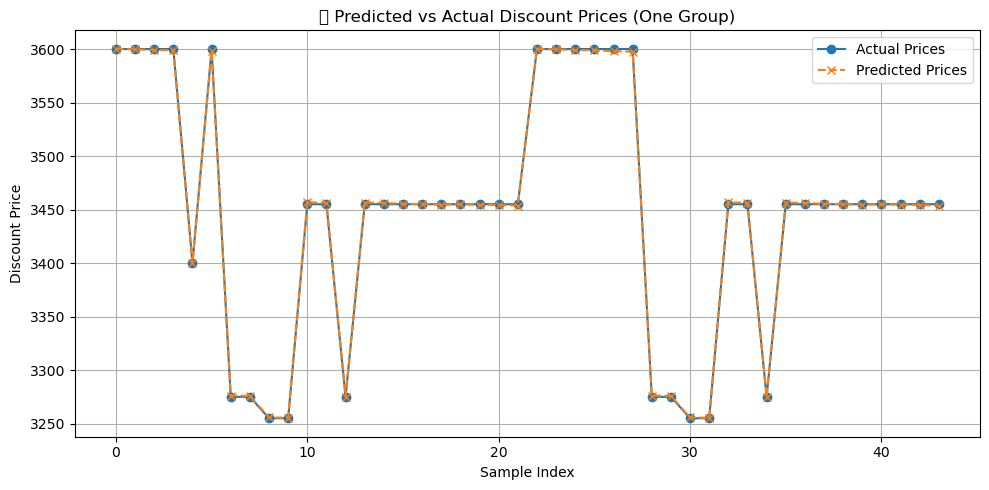

In [ ]:
# Cell 12: Analyze GPR Results – Summary & Visual Comparison

# --- GPR Summary Statistics ---
avg_r2 = gpr_results_df['R2 Score'].mean()
std_r2 = gpr_results_df['R2 Score'].std()
print(f"📊 Final average R² score (GPR): {avg_r2:.4f}")
print(f"📉 R² Standard Deviation: {std_r2:.4f}")

# --- Ensure results dataframe exists ---
assert 'gpr_results_df' in globals(), "❌ gpr_results_df not found. Please run the GPR cell first."

# --- Split GPR models into good and bad based on R² threshold ---
good_models_gpr = gpr_results_df[gpr_results_df['R2 Score'] >= 0].copy()
bad_models_gpr = gpr_results_df[gpr_results_df['R2 Score'] < 0].copy()

# --- Compute summary statistics for both groups ---
good_stats_gpr = good_models_gpr.describe().T
bad_stats_gpr = bad_models_gpr.describe().T

# --- Comparison table: Good vs Bad GPR models ---
summary_gpr = pd.DataFrame({
    'Good Mean': good_stats_gpr['mean'],
    'Good Std': good_stats_gpr['std'],
    'Bad Mean': bad_stats_gpr['mean'],
    'Bad Std': bad_stats_gpr['std'],
}).round(4)

# --- Display results ---
print(f"✅ Good GPR models: {len(good_models_gpr)}")
print(f"❌ Bad GPR models: {len(bad_models_gpr)}")
print("\n📊 Statistical Comparison Between Good and Bad GPR Models:")
display(summary_gpr)

# --- Visual: Actual vs Predicted for One Group (Example from Active Sampling) ---
plt.figure(figsize=(10, 5))
plt.plot(original_subset['Discount Price'].values, label='Actual Prices', marker='o')
plt.plot(result['final_predictions'], label='Predicted Prices', linestyle='--', marker='x')
plt.title('📈 Predicted vs Actual Discount Prices (One Group)')
plt.xlabel('Sample Index')
plt.ylabel('Discount Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 13: Evaluate GPR on test set (structure only, no output or plots)

def evaluate_gpr_on_test_set(grouped_df, train_df, test_df):
    results = []

    for _, row in tqdm(grouped_df.iterrows(), total=grouped_df.shape[0], desc="🧪 Evaluating GPR on test set"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Filter training group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code)
        ].copy()

        if train_group.shape[0] < 5:
            continue

        # Filter test group
        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()

        if test_group.shape[0] < 3:
            continue

        feature_cols = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms',
            'DayDiff', 'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_cols if f in train_group.columns]

        X_train = train_group[selected_features]
        y_train = train_group['Discount Price']

        X_test = test_group[selected_features]
        y_test = test_group['Discount Price']

        try:
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
        except Exception as e:
            r2 = None

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Test Size': len(y_test),
            'R2 GPR Test Score': r2
        })

    return pd.DataFrame(results)

# Run evaluation
gpr_test_results = evaluate_gpr_on_test_set(grouped, train_df, test_df)

In [ ]:
# Cell 14: GPR Test Set – Summary Statistics

# Drop any NaNs in case of failed model fits
gpr_test_results_clean = gpr_test_results.dropna(subset=['R2 GPR Test Score']).copy()

# Average R²
mean_r2_test_gpr = gpr_test_results_clean['R2 GPR Test Score'].mean()
std_r2_test_gpr = gpr_test_results_clean['R2 GPR Test Score'].std()

# Output stats
print(f"📊 GPR Test Set – Average R²: {mean_r2_test_gpr:.4f}")
print(f"📉 GPR Test Set – R² Standard Deviation: {std_r2_test_gpr:.4f}")
print(f"✅ Total Groups Evaluated: {len(gpr_test_results_clean)}")

# Preview first rows
display(gpr_test_results_clean.head())


# 📈 Visualize Train vs Test R² Distributions (GPR)

# Drop NaNs
train_r2 = gpr_results_df['R2 Score'].dropna()
test_r2 = gpr_test_results_clean['R2 GPR Test Score'].dropna()

# Create combined DataFrame for seaborn
combined_r2 = pd.DataFrame({
    'R2 Score': pd.concat([train_r2, test_r2], ignore_index=True),
    'Set': ['Train'] * len(train_r2) + ['Test'] * len(test_r2)
})

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_r2, x='Set', y='R2 Score', palette='Set2')
plt.title('GPR Model – R² Comparison (Train vs Test)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.9 - Compare models

In [ ]:
# Cell 15: Export Results & Summary

# Export results to CSV
results_df.to_csv("Output/base_model_results.csv", index=False)
gpr_results_df.to_csv("Output/gpr_model_results.csv", index=False)

# Summary print
print("✅ Export complete. Results saved to 'Output' folder.\n")

print("📊 Final Summary:")
print(f"- Base Model: {results_df.shape[0]} models | Avg R² = {results_df['R2 Score'].mean():.4f}")
print(f"- GPR Model : {gpr_results_df.shape[0]} models | Avg R² = {gpr_results_df['R2 Score'].mean():.4f}")

# Optional: show head of each file
print("\n📄 Base Model Preview:")
display(results_df.head())

print("\n📄 GPR Model Preview:")
display(gpr_results_df.head())